In [1]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
import cv2
import os
import random
from torch import nn
import matplotlib.pyplot as plt


c:\Users\andychen\anaconda3\envs\st\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 這裡是讀取所有圖片
def read_images_from_folders(root_folder, subfolders):
    images_dict = {}
    for folder_name in subfolders:
        folder_path = os.path.join(root_folder, folder_name)
        print(f"正在讀取資料夾: {folder_path}") # 增加提示，方便除錯
        images = []
        if not os.path.isdir(folder_path): # 檢查資料夾是否存在
            print(f"警告: 資料夾不存在 {folder_path}")
            images_dict[folder_name] = images # 即使資料夾不存在，也給它一個空列表
            continue

        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".jpg", ".png")):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                else:
                    print(f"無法讀取圖片: {img_path}")
        images_dict[folder_name] = images
        if not images:
            print(f"注意: 資料夾 {folder_name} 中沒有找到符合條件的圖片。")
    return images_dict


root_folder = r"C:\Users\andychen\Desktop\unet++\ETT-v3\Fold5"


subfolders = ["test", "testannot", "train", "trainannot", "val", "valannot"]
images_data = read_images_from_folders(root_folder, subfolders)

print("\n--- 讀取結果 ---")
for folder_name, images in images_data.items():
    print(f"{folder_name} 讀取 {len(images)} 張圖片")

train_images = images_data.get("train", [])
val_images = images_data.get("val", [])
test_images = images_data.get("test", [])
trainannot_images = images_data.get("trainannot", [])
valannot_images = images_data.get("valannot", [])
testannot_images = images_data.get("testannot", []) 


if train_images:
    print(f"\n成功讀取到 train 資料夾的第一張圖片，形狀: {train_images[0].shape}")
else:
    print("\n未讀取到 train 資料夾的圖片。")

if testannot_images: 
    print(f"成功讀取到 testannot 資料夾的第一張圖片，形狀: {testannot_images[0].shape}")
else:
    print("\n未讀取到 testannot 資料夾的圖片。")

正在讀取資料夾: C:\Users\andychen\Desktop\unet++\ETT-v3\Fold5\test
正在讀取資料夾: C:\Users\andychen\Desktop\unet++\ETT-v3\Fold5\testannot
正在讀取資料夾: C:\Users\andychen\Desktop\unet++\ETT-v3\Fold5\train
正在讀取資料夾: C:\Users\andychen\Desktop\unet++\ETT-v3\Fold5\trainannot
正在讀取資料夾: C:\Users\andychen\Desktop\unet++\ETT-v3\Fold5\val
正在讀取資料夾: C:\Users\andychen\Desktop\unet++\ETT-v3\Fold5\valannot

--- 讀取結果 ---
test 讀取 48 張圖片
testannot 讀取 48 張圖片
train 讀取 285 張圖片
trainannot 讀取 285 張圖片
val 讀取 48 張圖片
valannot 讀取 48 張圖片

成功讀取到 train 資料夾的第一張圖片，形狀: (2932, 2885)
成功讀取到 testannot 資料夾的第一張圖片，形狀: (3028, 2517)


In [3]:
#把圖片全都統一成256*256
processed_images_data = {}

def preprocess_images(images_data, target_size=(256, 256)):


    for folder_name, images in images_data.items():
        processed_images = []
        for image in images:
            resized_image = cv2.resize(image, target_size)

            processed_images.append(resized_image)

        processed_images_data[folder_name] = processed_images

    return processed_images_data

In [4]:
import cv2
import numpy as np
import random

def adjust_contrast_and_brightness(image, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
    alpha = random.uniform(*alpha_range)  # 對比度
    beta = random.randint(*beta_range)    # 亮度
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def random_affine_rotate(image, mask, angle_range=(-10, 10)):
    angle = random.uniform(*angle_range)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    image_rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    mask_rotated = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return image_rotated, mask_rotated

def random_scale_and_crop_pair(image, mask, target_size=(256, 256), scale_range=(1.0, 1.5)):
    scale = random.uniform(*scale_range)
    new_h = int(image.shape[0] * scale)
    new_w = int(image.shape[1] * scale)

    image_scaled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    mask_scaled = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    if new_h < target_size[1] or new_w < target_size[0]:
        padded_h = max(new_h, target_size[1])
        padded_w = max(new_w, target_size[0])
        img_pad = np.zeros((padded_h, padded_w), dtype=image.dtype)
        mask_pad = np.zeros((padded_h, padded_w), dtype=mask.dtype)
        img_pad[:new_h, :new_w] = image_scaled
        mask_pad[:new_h, :new_w] = mask_scaled
        image_scaled, mask_scaled = img_pad, mask_pad

    top = random.randint(0, image_scaled.shape[0] - target_size[1])
    left = random.randint(0, image_scaled.shape[1] - target_size[0])
    image_cropped = image_scaled[top:top + target_size[1], left:left + target_size[0]]
    mask_cropped = mask_scaled[top:top + target_size[1], left:left + target_size[0]]

    return image_cropped, mask_cropped

def random_flip_pair(image, mask):
    # 僅水平翻轉
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    return image, mask

def augment_train_images(train_images, trainannot_images, augment_times=2, target_size=(256, 256)):
    augmented_images = []
    augmented_annots = []

    for img, ann in zip(train_images, trainannot_images):
        base_img = cv2.resize(img, target_size)
        base_ann = cv2.resize(ann, target_size, interpolation=cv2.INTER_NEAREST)
        augmented_images.append(base_img)
        augmented_annots.append(base_ann)

        for _ in range(augment_times):
            aug_img, aug_ann = random_scale_and_crop_pair(img, ann, target_size)
            aug_img, aug_ann = random_affine_rotate(aug_img, aug_ann)
            aug_img, aug_ann = random_flip_pair(aug_img, aug_ann)
            aug_img = adjust_contrast_and_brightness(aug_img)
            augmented_images.append(aug_img)
            augmented_annots.append(aug_ann)

    return augmented_images, augmented_annots

# 使用增強
aug_train_images, aug_trainannot_images = augment_train_images(train_images, trainannot_images, augment_times=2)

# 更新 dict
augmented_images_data = images_data.copy()
augmented_images_data["train"] = aug_train_images
augmented_images_data["trainannot"] = aug_trainannot_images

# 驗證
print(f"train 增強後圖片數量: {len(augmented_images_data['train'])}")
print(f"trainannot 增強後圖片數量: {len(augmented_images_data['trainannot'])}")


train 增強後圖片數量: 855
trainannot 增強後圖片數量: 855


In [12]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

processed_images_data = preprocess_images(images_data)

# 自訂 Dataset 類別
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        assert len(images) == len(masks), "影像與標註數量不一致"
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # 灰階轉 float32 並標準化
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # 增加 channel 維度
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# 建立 Dataset 與 DataLoader（使用增強後的 train 和前處理後的 val）
train_dataset = SegmentationDataset(
    images=augmented_images_data["train"],
    masks=augmented_images_data["trainannot"]
)

val_dataset = SegmentationDataset(
    images=processed_images_data["val"], # <-- 修改這裡！
    masks=processed_images_data["valannot"] # <-- 修改這裡！
)
test_dataset = SegmentationDataset(
    images=processed_images_data["test"],
    masks=processed_images_data["testannot"]
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [6]:
print(f"訓練資料集大小：{len(train_dataset)}")
print(f"驗證資料集大小：{len(val_dataset)}")
print(f"測試資料集大小：{len(test_dataset)}")

# 檢查資料是否正確載入
for i in range(3):
    img, mask = test_dataset[i]
    print(f"測試資料集第 {i+1} 張影像形狀：{img.shape}, 標註形狀：{mask.shape}")

訓練資料集大小：855
驗證資料集大小：48
測試資料集大小：48
測試資料集第 1 張影像形狀：torch.Size([1, 256, 256]), 標註形狀：torch.Size([1, 256, 256])
測試資料集第 2 張影像形狀：torch.Size([1, 256, 256]), 標註形狀：torch.Size([1, 256, 256])
測試資料集第 3 張影像形狀：torch.Size([1, 256, 256]), 標註形狀：torch.Size([1, 256, 256])


In [7]:
''' # Input In [14] 這個儲存格的程式碼修改如下：

# Unet++ Training Script for Image Segmentation

import os
import torch
import numpy as np
import cv2
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics # <-- 匯入 torchmetrics

# Seed for reproducibility
seed_everything(42)

# 移除原本的 iou_metric 函數定義，我們將使用 torchmetrics

# 移除原本的 mean_error_cm 和 accuracy_within 函數定義，如果需要，它們應該在 LightningModule 中或作為 LightningModule 的成員

# 移除原本的 model 定義

# 移除原本的 combined_loss 函數定義

# 移除原本的 optimizer 定義


# --> *** 新增一個 PyTorch Lightning Module 來封裝模型和訓練邏輯 *** <--
class SegmentationModel(pl.LightningModule):
    def __init__(self, encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, num_classes=1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters() # 可選：自動儲存 __init__ 的參數

        # 1. 定義模型
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=num_classes,
            activation="sigmoid"
        )

        # 2. 定義損失函數
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = nn.BCELoss()

        # 3. 定義指標
        # 使用 torchmetrics 來計算和紀錄指標
        self.train_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
        self.val_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
        # 如果需要 endpoint 相關的指標，也應該在這裡初始化

    def forward(self, x):
        # 定義前向傳播
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # 定義訓練步驟
        images, masks = batch
        outputs = self.forward(images) # 前向傳播

        # 計算損失
        loss = self.dice_loss(outputs, masks) + self.bce_loss(outputs, masks)

        # 記錄損失和指標
        self.log('train_loss', loss)
        self.train_iou(outputs, masks.int()) # 計算 IoU
        self.log('train_iou', self.train_iou, on_step=False, on_epoch=True) # 記錄訓練 IoU (每個 Epoch 聚合)

        return loss

    def validation_step(self, batch, batch_idx):
        # 定義驗證步驟
        images, masks = batch
        outputs = self.forward(images) # 前向傳播

        # 計算損失
        loss = self.dice_loss(outputs, masks) + self.bce_loss(outputs, masks)

        # 記錄損失和指標
        self.log('val_loss', loss)
        self.val_iou(outputs, masks.int()) # 計算 IoU
        self.log('val_iou', self.val_iou, on_step=False, on_epoch=True) # 記錄驗證 IoU (每個 Epoch 聚合)

        return loss

    def configure_optimizers(self):
        # 定義優化器
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        # 您可以在這裡設定學習率排程器，如果需要的話
        return optimizer
# --> *** Lightning Module 定義結束 *** <--


# Checkpoint and Early Stopping (這些設定可以保留，它們與 Lightning Trainer 搭配使用)
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou', # <-- 監控驗證 IoU
    mode='max',
    save_top_k=1,
    dirpath='./checkpoints',
    filename='best-checkpoint'
)
early_stopping = EarlyStopping(
    monitor='val_iou', # <-- 監控驗證 IoU
    patience=10,
    mode='max'
)

# 實例化新的 Lightning 模型
# 注意：我們現在建立的是 SegmentationModel 的實例，而不是直接 smp.UnetPlusPlus 的實例
model = SegmentationModel(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    num_classes=1, # 這裡改為 num_classes 以符合 LightningModule 的參數名稱
    learning_rate=3e-5 # 傳遞學習率參數
)


# Training
trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping],
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10,
    # logger=..., # 您可以選擇增加一個 logger，例如 TensorBoardLogger
)

# 確保 train_loader 和 val_loader 在執行到這裡時已經被定義
# 根據您之前的錯誤，您需要確保定義 DataLoader 的那個儲存格已經成功執行
# trainer.fit(model, train_loader, val_loader) # <-- 傳入我們新的 Lightning 模型實例

# 根據您上次提供的錯誤訊息，DataLoader 的變數名稱 train_loader 和 val_loader 在您遇到錯誤的儲存格 (Input In [10]) 中定義。
# 在這個新的程式碼片段 (Input In [14]) 中，您也需要確保 train_loader 和 val_loader 已經被定義。
# 這意味著您需要執行包含 DataLoader 定義的那個儲存格（Input In [10] 及其修正後的版本）
# 然後再執行包含這個訓練程式碼的儲存格。
# 假設您已經執行了定義 DataLoader 的儲存格，現在可以呼叫 fit：
trainer.fit(model, train_loader, val_loader)


# Model Training Complete
print("Training complete. Best model saved.") '''

' # Input In [14] 這個儲存格的程式碼修改如下：\n\n# Unet++ Training Script for Image Segmentation\n\nimport os\nimport torch\nimport numpy as np\nimport cv2\nimport segmentation_models_pytorch as smp\nfrom torch.utils.data import DataLoader\nfrom torch import nn, optim\nfrom torchvision import transforms\nimport pytorch_lightning as pl\nfrom pytorch_lightning import seed_everything, Trainer\nfrom pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping\nimport torchmetrics # <-- 匯入 torchmetrics\n\n# Seed for reproducibility\nseed_everything(42)\n\n# 移除原本的 iou_metric 函數定義，我們將使用 torchmetrics\n\n# 移除原本的 mean_error_cm 和 accuracy_within 函數定義，如果需要，它們應該在 LightningModule 中或作為 LightningModule 的成員\n\n# 移除原本的 model 定義\n\n# 移除原本的 combined_loss 函數定義\n\n# 移除原本的 optimizer 定義\n\n\n# --> *** 新增一個 PyTorch Lightning Module 來封裝模型和訓練邏輯 *** <--\nclass SegmentationModel(pl.LightningModule):\n    def __init__(self, encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, num_classes=1, learning_rate=1e-

In [8]:
''' import os
import torch
import numpy as np
import cv2
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics

seed_everything(42)

class SegmentationModel(pl.LightningModule):
    def __init__(self, encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, num_classes=1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # 模型
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=num_classes,
            activation="sigmoid",
            decoder_dropout=0.2
        )

        # 損失
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = nn.BCELoss()

        # 指標
        self.train_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
        self.val_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)

        # 每公分像素數：每 72 pixel = 1 cm
        self.pixel_per_cm = 72.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)
        loss = self.dice_loss(outputs, masks) + self.bce_loss(outputs, masks)
        self.log('train_loss', loss)
        self.train_iou(outputs, masks.int())
        self.log('train_iou', self.train_iou, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)
        loss = self.dice_loss(outputs, masks) + self.bce_loss(outputs, masks)
        self.log('val_loss', loss)
        self.val_iou(outputs, masks.int())
        self.log('val_iou', self.val_iou, on_step=False, on_epoch=True)
        return loss

    def extract_tip_y(self, mask):
        # mask: tensor (B, 1, H, W) or (B, H, W)
        if mask.ndim == 4:
            mask = mask.squeeze(1)
        y_coords = []
        for m in mask:
            indices = torch.nonzero(m > 0.5, as_tuple=False)
            if len(indices) == 0:
                y_coords.append(torch.tensor(0.0, device=mask.device))  # 預測不到，設為 0
            else:
                y_coords.append(indices[:, 0].max().float())  # y 座標最大值（最下方）
        return torch.stack(y_coords)

    def compute_avg_acc_cm(self, preds_y, targets_y):
        abs_diff = torch.abs(preds_y - targets_y)
        return (abs_diff / self.pixel_per_cm).mean()

    def compute_acc_within_threshold(self, preds_y, targets_y, threshold_cm):
        abs_diff = torch.abs(preds_y - targets_y)
        within_threshold = (abs_diff / self.pixel_per_cm) <= threshold_cm
        return within_threshold.float().mean() * 100  # 百分比

    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)

        # IoU
        test_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1).to(self.device)
        iou_score = test_iou(outputs, masks.int())

        # 提取端點 Y 座標
        pred_y = self.extract_tip_y(outputs)
        gt_y = self.extract_tip_y(masks)

        # 公分誤差計算
        avg_acc_cm = self.compute_avg_acc_cm(pred_y, gt_y)
        acc_0_5_cm = self.compute_acc_within_threshold(pred_y, gt_y, 0.5)
        acc_1_0_cm = self.compute_acc_within_threshold(pred_y, gt_y, 1.0)

        # Logging
        self.log('test_iou', iou_score, prog_bar=True)
        self.log('test_avg_acc_cm', avg_acc_cm, prog_bar=True)
        self.log('test_acc_0.5_cm', acc_0_5_cm, prog_bar=True)
        self.log('test_acc_1.0_cm', acc_1_0_cm, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    save_top_k=1,
    dirpath='./checkpoints',
    filename='best-checkpoint'
)
early_stopping = EarlyStopping(
    monitor='val_iou',
    patience=10,
    mode='max'
)

# Model
model = SegmentationModel(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    num_classes=1,
    learning_rate=1e-4
    
)

# Trainer
trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping],
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10,
)

# 執行訓練
trainer.fit(model, train_loader, val_loader)
print("Training complete. Best model saved.")

trainer.test(model, dataloaders=test_loader, ckpt_path='best')
 '''

' import os\nimport torch\nimport numpy as np\nimport cv2\nimport segmentation_models_pytorch as smp\nfrom torch.utils.data import DataLoader\nfrom torch import nn, optim\nfrom torchvision import transforms\nimport pytorch_lightning as pl\nfrom pytorch_lightning import seed_everything, Trainer\nfrom pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping\nimport torchmetrics\n\nseed_everything(42)\n\nclass SegmentationModel(pl.LightningModule):\n    def __init__(self, encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, num_classes=1, learning_rate=1e-4):\n        super().__init__()\n        self.save_hyperparameters()\n\n        # 模型\n        self.model = smp.UnetPlusPlus(\n            encoder_name=encoder_name,\n            encoder_weights=encoder_weights,\n            in_channels=in_channels,\n            classes=num_classes,\n            activation="sigmoid",\n            decoder_dropout=0.2\n        )\n\n        # 損失\n        self.dice_loss = smp.losses.Di

In [9]:
print(f"測試資料集大小：{len(test_loader.dataset)}")
for batch in test_loader:
    print(f"批次大小：{len(batch[0])}")

測試資料集大小：48
批次大小：8
批次大小：8
批次大小：8
批次大小：8
批次大小：8
批次大小：8


In [10]:
#version41
''' import os
import torch
import numpy as np
import cv2
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
from pprint import pprint


seed_everything(42)

class SegmentationModel(pl.LightningModule):
    def __init__(self, encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, num_classes=1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # 模型
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=num_classes,
            activation="sigmoid",
            decoder_dropout=0.2
        )

        # 損失
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = nn.BCELoss()

        # 指標
        self.train_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
        self.val_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)

        # 每公分像素數：每 72 pixel = 1 cm
        self.pixel_per_cm = 72.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)
        loss = 0.5 * self.dice_loss(outputs, masks) + 0.5 * self.bce_loss(outputs, masks)
        self.log('train_loss', loss)
        preds = (outputs > 0.5).float()
        self.train_iou(preds, masks.int())
        self.log('train_iou', self.train_iou, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)
        loss = 0.5 * self.dice_loss(outputs, masks) + 0.5 * self.bce_loss(outputs, masks)
        self.log('val_loss', loss)
        preds = (outputs > 0.5).float()
        self.val_iou(preds, masks.int())
        self.log('val_iou', self.val_iou, on_step=False, on_epoch=True)
        return loss

    def extract_tip_y(self, mask):
        # mask: tensor (B, 1, H, W) or (B, H, W)
        if mask.ndim == 4:
            mask = mask.squeeze(1)
        y_coords = []
        for m in mask:
            indices = torch.nonzero(m > 0.5, as_tuple=False)
            if len(indices) == 0:
                y_coords.append(torch.tensor(0.0, device=mask.device))  # 預測不到，設為 0
            else:
                y_coords.append(indices[:, 0].max().float())  # y 座標最大值（最下方）
        return torch.stack(y_coords)

    def compute_avg_acc_cm(self, preds_y, targets_y):
        abs_diff = torch.abs(preds_y - targets_y)
        return (abs_diff / self.pixel_per_cm).mean()

    def compute_acc_within_threshold(self, preds_y, targets_y, threshold_cm):
        abs_diff = torch.abs(preds_y - targets_y)
        within_threshold = (abs_diff / self.pixel_per_cm) <= threshold_cm
        return within_threshold.float().mean() * 100  # 百分比

    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)
        outputs = (outputs > 0.5).float()


        # IoU
        test_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1).to(self.device)
        iou_score = test_iou(outputs, masks.int())

        # 提取端點 Y 座標
        pred_y = self.extract_tip_y(outputs)
        gt_y = self.extract_tip_y(masks)

        # 公分誤差計算
        avg_acc_cm = self.compute_avg_acc_cm(pred_y, gt_y)
        acc_0_5_cm = self.compute_acc_within_threshold(pred_y, gt_y, 0.5)
        acc_1_0_cm = self.compute_acc_within_threshold(pred_y, gt_y, 1.0)

        # Logging
        self.log('test_iou', iou_score, prog_bar=True)
        self.log('test_avg_acc_cm', avg_acc_cm, prog_bar=True)
        self.log('test_acc_0.5_cm', acc_0_5_cm, prog_bar=True)
        self.log('test_acc_1.0_cm', acc_1_0_cm, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    save_top_k=1,
    dirpath='./checkpoints',
    filename='best-checkpoint'
)
early_stopping = EarlyStopping(
    monitor='val_iou',
    patience=10,
    mode='max'
)

# Model
model = SegmentationModel(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    num_classes=1,
    learning_rate=1e-4
    
)

# Trainer
trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping],
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10,
)

# 執行訓練
trainer.fit(model, train_loader, val_loader)
print("Training complete. Best model saved.")

 '''

' import os\nimport torch\nimport numpy as np\nimport cv2\nimport segmentation_models_pytorch as smp\nfrom torch.utils.data import DataLoader\nfrom torch import nn, optim\nfrom torchvision import transforms\nimport pytorch_lightning as pl\nfrom pytorch_lightning import seed_everything, Trainer\nfrom pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping\nimport torchmetrics\nfrom pprint import pprint\n\n\nseed_everything(42)\n\nclass SegmentationModel(pl.LightningModule):\n    def __init__(self, encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, num_classes=1, learning_rate=1e-4):\n        super().__init__()\n        self.save_hyperparameters()\n\n        # 模型\n        self.model = smp.UnetPlusPlus(\n            encoder_name=encoder_name,\n            encoder_weights=encoder_weights,\n            in_channels=in_channels,\n            classes=num_classes,\n            activation="sigmoid",\n            decoder_dropout=0.2\n        )\n\n        # 損失\n        s

In [13]:
import os
import torch
import numpy as np
import cv2
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback
import torchmetrics
from pprint import pprint

# 設定隨機種子
seed_everything(42)


# 定義模型類別
class PetModel(pl.LightningModule):
    def __init__(self, arch="UnetPlusPlus", encoder_name="resnet34", in_channels=1, out_classes=1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # 初始化模型架構
        self.model = smp.create_model(
            arch, 
            encoder_name=encoder_name, 
            in_channels=in_channels, 
            classes=out_classes, 
            activation="sigmoid",
            decoder_dropout=0.4#初始0.2
        )

        # 損失函數
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = nn.BCELoss()

        # 指標
        self.train_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
        self.val_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)

        # 每公分像素數：每 72 pixel = 1 cm
        self.pixel_per_cm = 72.0

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, stage):
        images, masks = batch
        outputs = self.forward(images)

        # 計算損失
        loss = 0.5 * self.dice_loss(outputs, masks) + 0.5 * self.bce_loss(outputs, masks)
        preds = (outputs > 0.5).float()

        # 計算 IoU
        iou_metric = self.train_iou if stage == "train" else self.val_iou
        iou_metric(preds, masks.int())

        # 紀錄損失與指標
        self.log(f'{stage}_loss', loss, prog_bar=True)
        self.log(f'{stage}_iou', iou_metric, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def extract_tip_y(self, mask):
        # mask: tensor (B, 1, H, W) or (B, H, W)
        if mask.ndim == 4:
            mask = mask.squeeze(1)
        y_coords = []
        for m in mask:
            indices = torch.nonzero(m > 0.5, as_tuple=False)
            if len(indices) == 0:
                y_coords.append(torch.tensor(0.0, device=mask.device))  # 預測不到，設為 0
            else:
                y_coords.append(indices[:, 0].max().float())  # y 座標最大值（最下方）
        return torch.stack(y_coords)

    def compute_avg_acc_cm(self, preds_y, targets_y):
        abs_diff = torch.abs(preds_y - targets_y)
        return (abs_diff / self.pixel_per_cm).mean()

    def compute_acc_within_threshold(self, preds_y, targets_y, threshold_cm):
        abs_diff = torch.abs(preds_y - targets_y)
        within_threshold = (abs_diff / self.pixel_per_cm) <= threshold_cm
        return within_threshold.float().mean() * 100  # 百分比

    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)
        outputs = (outputs > 0.5).float()

        # IoU
        test_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1).to(self.device)
        iou_score = test_iou(outputs, masks.int())

        # 提取端點 Y 座標
        pred_y = self.extract_tip_y(outputs)
        gt_y = self.extract_tip_y(masks)

        # 公分誤差計算
        avg_acc_cm = self.compute_avg_acc_cm(pred_y, gt_y)
        acc_0_5_cm = self.compute_acc_within_threshold(pred_y, gt_y, 0.5)
        acc_1_0_cm = self.compute_acc_within_threshold(pred_y, gt_y, 1.0)

        # Logging
        self.log('test_iou', iou_score, prog_bar=True)
        self.log('test_avg_acc_cm', avg_acc_cm, prog_bar=True)
        self.log('test_acc_0.5_cm', acc_0_5_cm, prog_bar=True)
        self.log('test_acc_1.0_cm', acc_1_0_cm, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }


# IoU Callback
class IouCallBack(Callback):
    def __init__(self):
        super().__init__()
        self.train_ious = []
        self.valid_ious = []

    def on_validation_epoch_end(self, trainer, pl_module):
        self.train_ious.append(trainer.callback_metrics.get("train_iou"))
        self.valid_ious.append(trainer.callback_metrics.get("val_iou"))

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    save_top_k=1,
    dirpath='./checkpoints',
    filename='best-checkpoint'
)
early_stopping = EarlyStopping(
    monitor='val_iou',
    patience=10,
    mode='max'
)
iou_callback = IouCallBack()

# Model
model = PetModel(
    arch="UnetPlusPlus",  # 模型架構
    encoder_name="resnet18",  # 編碼器
    in_channels=1,  # 輸入通道數
    out_classes=1,  # 輸出通道數
    learning_rate=1e-4  # 學習率
)

# Trainer
trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping, iou_callback],
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10,
)

# 執行訓練
trainer.fit(model, train_loader, val_loader)
print("Training complete. Best model saved.")


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\andychen\anaconda3\envs\st\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\andychen\Desktop\unet++\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UnetPlusPlus       | 16.0 M | train
1 | dice_loss | DiceLoss           | 0      | train
2 | bce_loss  | BCELoss            | 0      | train
3 | train_iou | BinaryJaccardIndex | 0      | train
4 | val_iou   | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
16.0 M    Trainable params
0         Non-trainable params
16.0 M    Total params
63.857    Total estimated model params size (MB)
222       Modules in train mode
0         Modules in eval mode


Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\andychen\anaconda3\envs\st\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\andychen\anaconda3\envs\st\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 107/107 [02:23<00:00,  0.75it/s, v_num=53, train_loss=0.497, val_loss=0.498, val_iou=0.411, train_iou=0.854]  
Training complete. Best model saved.


In [14]:
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]
[{'val_iou': 0.41146549582481384, 'val_loss': 0.4976024329662323}]


In [15]:
test_metrics = trainer.test(model, dataloaders=test_loader, ckpt_path='best')
pprint(test_metrics)


Restoring states from the checkpoint path at C:\Users\andychen\Desktop\unet++\checkpoints\best-checkpoint-v32.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\andychen\Desktop\unet++\checkpoints\best-checkpoint-v32.ckpt
c:\Users\andychen\anaconda3\envs\st\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_0.5_cm      │           100.0           │
│      test_acc_1.0_cm      │           100.0           │
│      test_avg_acc_cm      │    0.06655093282461166    │
│         test_iou          │     0.597009003162384     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc_0.5_cm': 100.0,
  'test_acc_1.0_cm': 100.0,
  'test_avg_acc_cm': 0.06655093282461166,
  'test_iou': 0.597009003162384}]


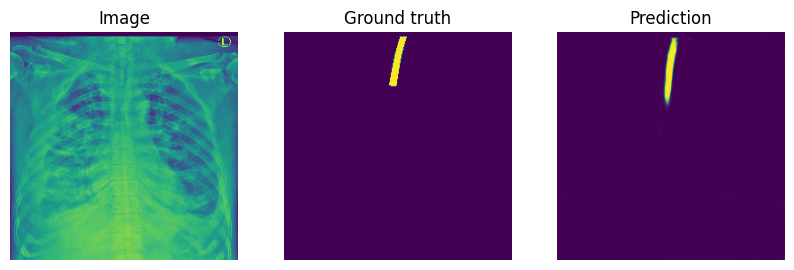

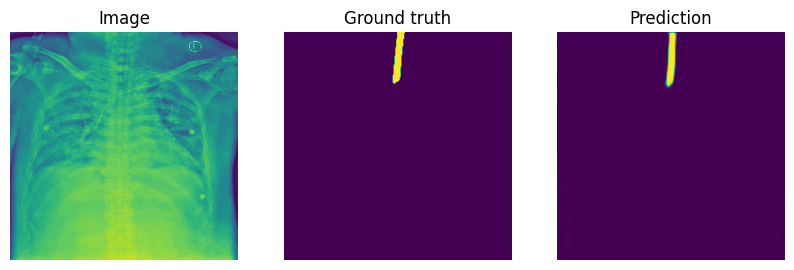

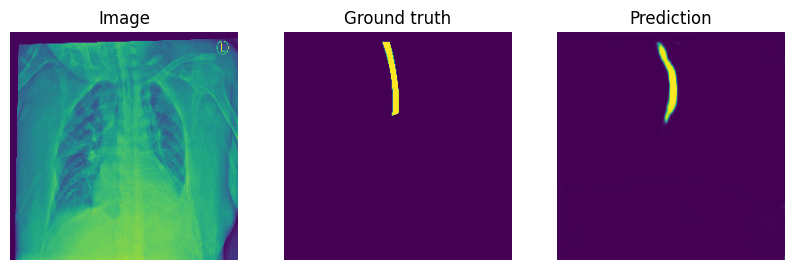

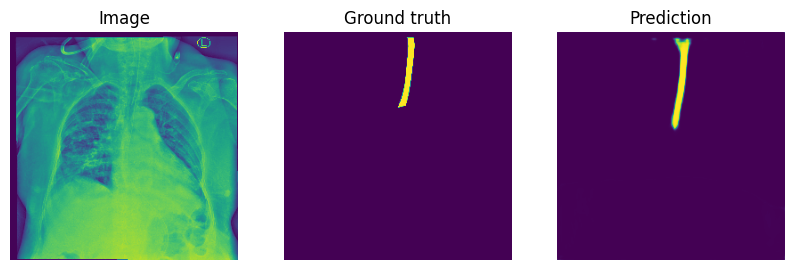

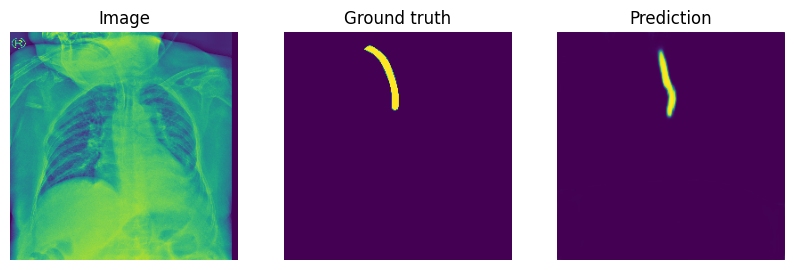

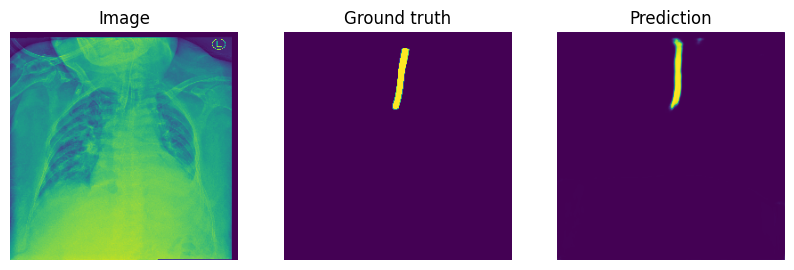

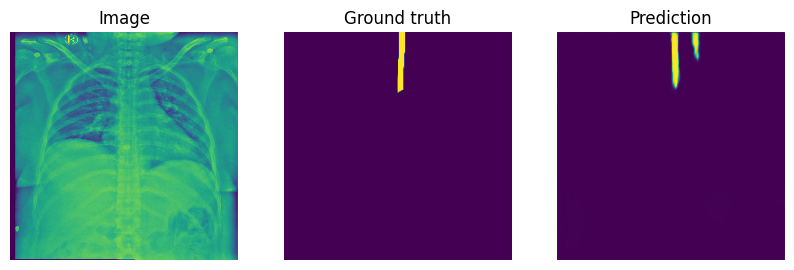

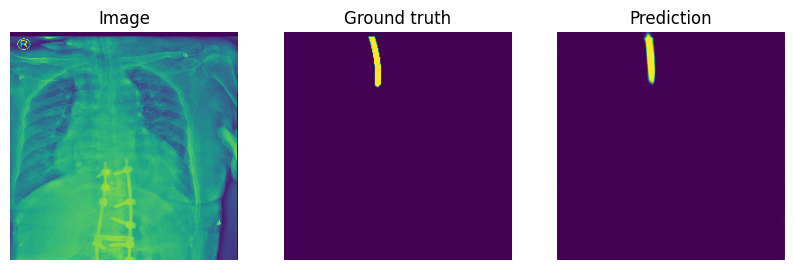

In [16]:
import torch
import matplotlib.pyplot as plt # 確保有這行
from itertools import islice # 確保有這行
# 可能還需要 numpy，如果前面的程式碼沒有匯入的話
import numpy as np
from itertools import islice
# 指定要顯示的批次索引
batch_index = 1

# 使用迭代器來訪問指定的批次
batch = next(islice(test_loader, batch_index, batch_index + 1))

# batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])  # 使用整數索引訪問圖像
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze())  # just squeeze classes dim
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze())  # just squeeze classes dim
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
